In [184]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.optim as optim

from PIL import Image
import requests
import numpy as np
from tqdm import tqdm


In [172]:
# Images between -1 and 1, size 28x28
dataset = MNIST(root='./data', download=True, transform=Compose([Resize((28, 28)), ToTensor(), Lambda(lambda x: (x - 1/2) * 2), ]))
train_data = DataLoader(dataset, batch_size=32, shuffle=True)

test_image = next(iter(train_data))[0][0]


In [41]:
# Making a very simple model to make sure it works

class SimpleModel(nn.Module):
    def __init__(self, num_of_channels):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(num_of_channels, 32, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, num_of_channels, 2, stride=2),
            nn.ReLU()
        )


    def forward(self, x):
        # input shape (batch_size, num_channels, height, width)
        encode = self.encoder(x)
        decode = self.decoder(encode)
        
        return decode


In [54]:
def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)


In [65]:
timesteps = 300

# define beta schedule
betas = linear_beta_schedule(timesteps=timesteps)

# define alphas 
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)


# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)


def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)



In [137]:
def reverse_transform(img):
    img = img.detach().cpu().numpy()
    img = img.squeeze()
    return img

In [138]:
# forward diffusion (using the nice property)
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x_start.shape
    )

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise


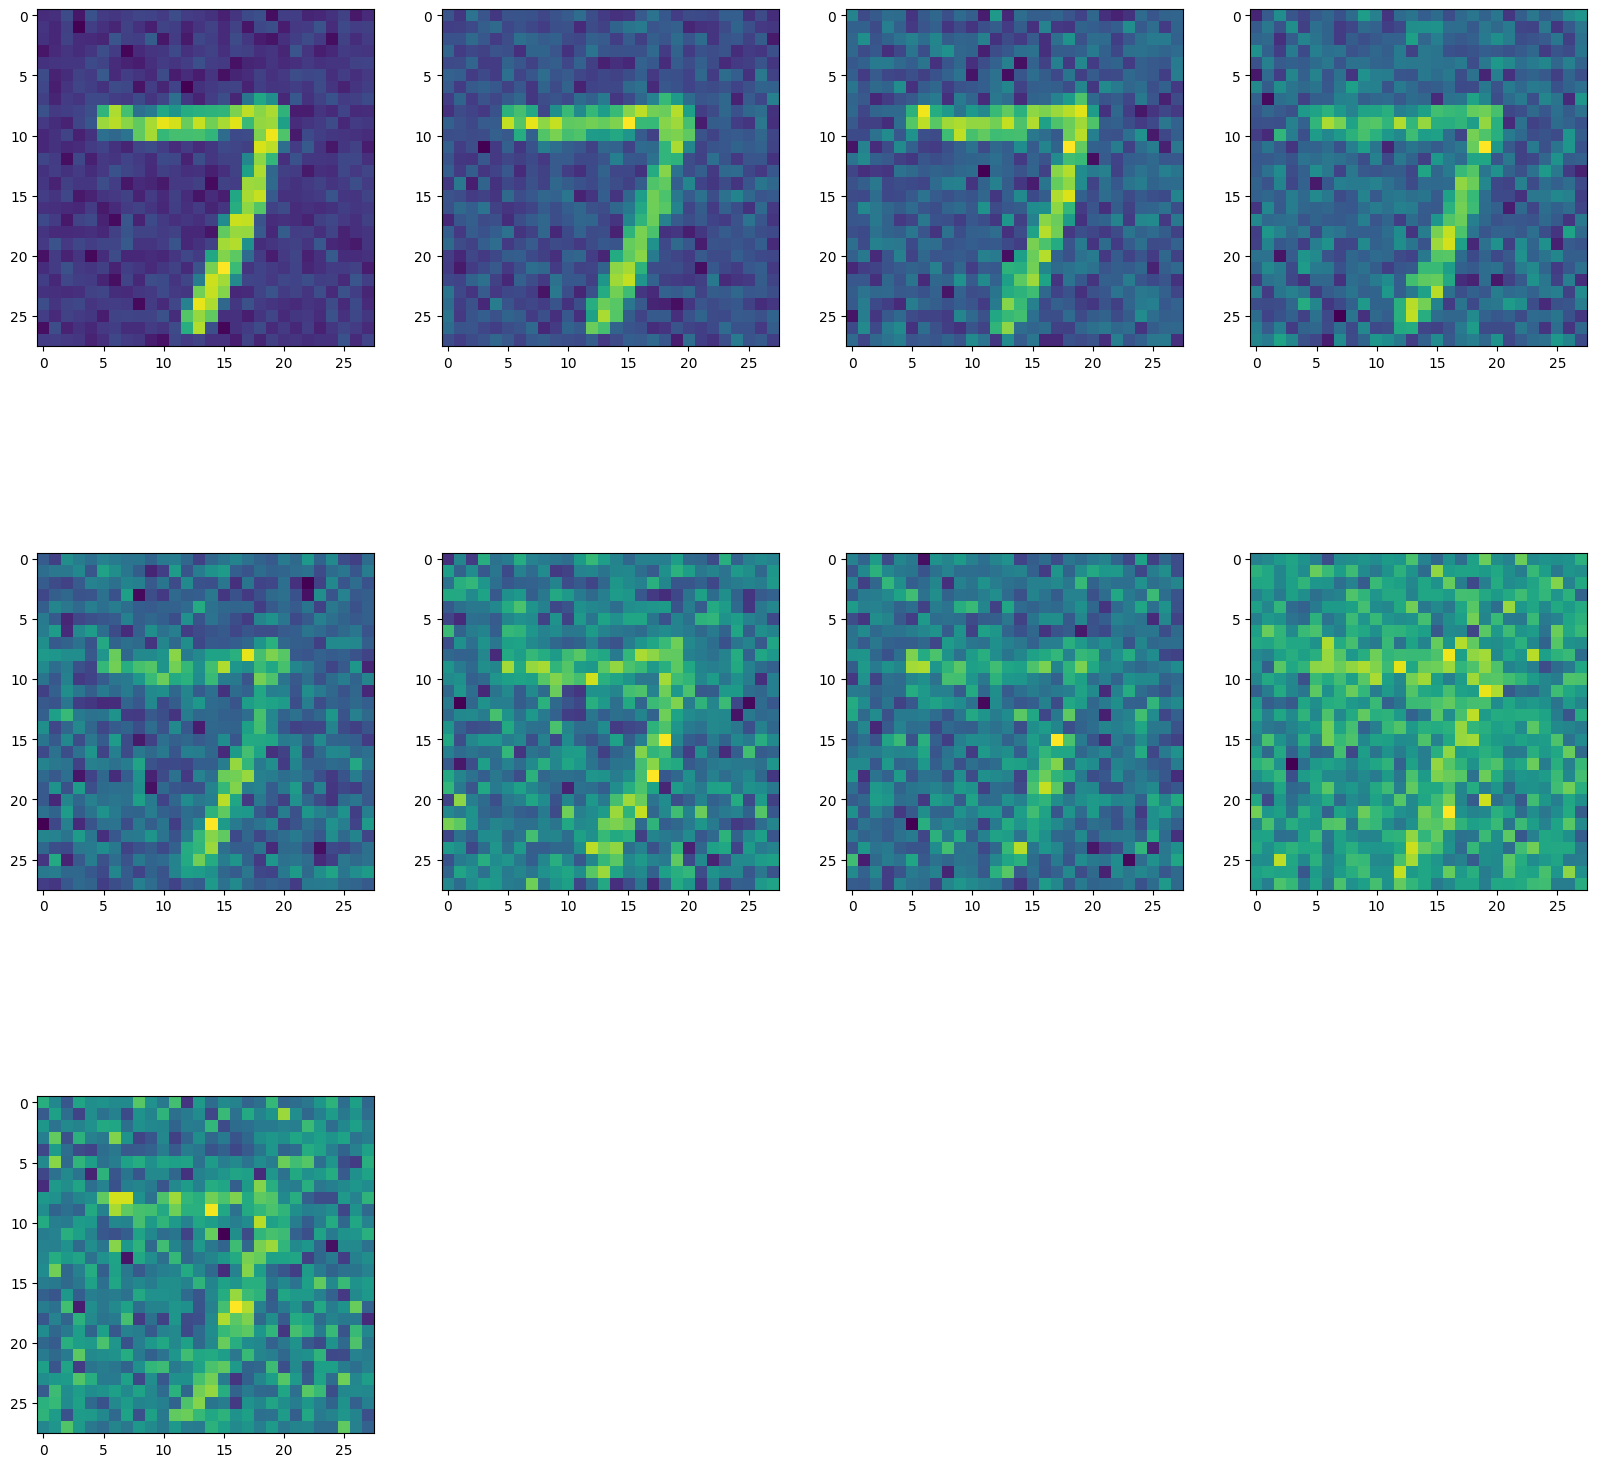

In [156]:
def get_noisy_image(x_start, t):
  # add noise
  x_noisy = q_sample(x_start, t=t)
  # turn back into PIL image
  noisy_image = reverse_transform(x_noisy.squeeze())

  return noisy_image


timesteps = [torch.tensor([i]) for i in range(0, 100, 10)]


plt.figure(figsize=(20, 20))
for i in range(1, len(timesteps)):
  plt.subplot(3,4, i)
  t = timesteps[i]
  plt.imshow(get_noisy_image(test_image, t))



In [157]:
def loss(denoise_model, x_start, t):
    x_noisy = q_sample(x_start, t=t)
    x_denoised = denoise_model(x_noisy)
    
    # calculate loss
    loss = F.mse_loss(x_denoised, x_start)

    return loss

In [183]:
@torch.no_grad()
def p_sample(model, x, t, t_index):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)
    
    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise 
    

@torch.no_grad()
def p_sample_loop(model, shape):
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)
    imgs = []

    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i)
        imgs.append(img.cpu().numpy())
    return imgs

@torch.no_grad()
def sample(model, image_size, batch_size=16, channels=3):
    return p_sample_loop(model, shape=(batch_size, channels, image_size, image_size))

In [185]:
model = SimpleModel(1)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 10
for epoch in range(epochs):
    for step, batch in enumerate(train_data):
      optimizer.zero_grad()

      batch_size = batch["pixel_values"].shape[0]
      batch = batch["pixel_values"]

      # Algorithm 1 line 3: sample t uniformally for every example in the batch
      t = torch.randint(0, timesteps, (batch_size,)).long()

      loss = losses(model, batch, t, loss_type="huber")

      if step % 100 == 0:
        print("Loss:", loss.item())

      loss.backward()
      optimizer.step()